In [1]:
import numpy as np
import pandas as pd 
import glob

#idx = idx[1:]
#dataraw = np.loadtxt('aparcsubject_100206.dat')
#data= dataraw[1:,].copy()
ROI = pd.read_csv('labelROI.csv',header=None)
ROI =ROI.values[:,1]
ROIraw = pd.read_csv('fsaverage.aparc.lut.txt',header=None)
#print(data)
import numpy.fft as fft
import scipy.stats as stats
# social=np.loadtxt('social_100206.dat')
# motor =np.loadtxt('motor_100206.dat')
# emo= np.loadtxt('emotion_100206.dat')
# lang=np.loadtxt('language_100307.dat')

/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/junhaozhu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
import geomstats.backend as gs
import geomstats.visualization as visualization


from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from geomstats.geometry import spd_matrices

INFO: Using numpy backend


In [4]:
files = glob.glob('fMRIaparcparcellationLanguage/*.dat')

# Assume space-delimited text files
#dfs = [pd.read_csv(f, delim_whitespace=True, header=None) for f in files]

In [5]:
raw_data = np.zeros((len(files),69,316))
for i in range(len(files)):
    #num = files[i]
    #name =str(f'fMRIaparcparcellationLanguage/aparcsubject_{num}.dat')
    raw_data[i,:,:] =  np.loadtxt(files[i])

In [5]:
len(files)

637

In [6]:
idx = np.loadtxt('templateindex.txt',dtype=int)
ROI_select = ['L_superiortemporal','L_middletemporal','R_middletemporal']
ROI_select_idx=[]
ROI_aug=np.insert(ROI, 0,'others' )
ROI_aug = np.delete(ROI_aug, [4, 39])
for i in range(ROI_aug.shape[0]):
    if ROI_aug [i] in ROI_select:
        ROI_select_idx.append(i)
#tempidx =np.loadtxt('templateindex.txt',dtype=int)
# ROI_aug2=np.insert(ROI, 0,'others' )
# ROI_aug2=ROI_aug2[tempidx]
#ROI_aug2==ROI_aug

In [7]:
data_ROI = raw_data[:,ROI_select_idx,:]
#data_ROI.shape
data_ROI=data_ROI

In [8]:
MWsize = 30
n_subjects, n_rois, n_timepoints = data_ROI.shape
n_windows = n_timepoints - MWsize + 1
cov_matrices = np.zeros((n_subjects, n_windows, n_rois, n_rois))
for subj in range(n_subjects):
    for t in range(n_windows):
        # Extract data in current window: shape [3,MWsize]
        window_data = data_ROI[subj, :, t:(t+MWsize)]

        # Compute covariance across time: shape [4, 4]
        cov = np.cov(window_data, rowvar=True) /1000 # rows = ROIs

        cov_matrices[subj, t] = cov


In [9]:
n_windows,n_timepoints

(287, 316)

In [10]:
d = n_rois
mfd = spd_matrices.SPDMetricAffine(n=d, power_affine=1)
aux= spd_matrices.SPDMatrices(n=d)


Pop_cov = np.zeros((n_windows, n_rois, n_rois))
for i in range(n_windows):
    fmean = FrechetMean(metric=mfd)
    fmean.fit(cov_matrices[:,i,:,:])
    mean =fmean.estimate_
    Pop_cov[i]=mean

In [12]:
np.save('Pop_cov.npy',Pop_cov)

In [11]:
def E_comp(mu):
    sqrt_mu = gs.linalg.sqrtm(mu)
    E = np.zeros((6, 3, 3))
    k = 0
    for i in range(3):
        for j in range(i, 3):
            eiej = np.zeros((3, 3))
            if (i == j):
                eiej[i, i] = 1
                # E[k,:,:]=np.dot(sqrt_mu,np.dot(eiej,sqrt_mu))
            else:
                eiej[i, j] = eiej[j, i] = 1 / np.sqrt(2)

            E[k, :, :] = np.dot(sqrt_mu, np.dot(eiej, sqrt_mu))

            k = k + 1
    return E


def Hess(mu, Y, V):
    # mu: base point
    # Y: pt to map
    # V: direction
    # mu_root: square root of mu
    n = Y.shape[0]

    H = np.zeros((n, 3, 3))
    for k in range(n):
        # W = mfd.log(Y[k],mu)
        Yinv = np.linalg.inv(Y[k])
        res = np.dot(V, aux.logm(np.dot(Yinv, mu))
                     ) - np.dot(aux.logm(np.dot(mu, Yinv)), V
                                ) + 2 * np.dot(mu, aux.differential_log(np.dot(Yinv, V), np.dot(Yinv, mu)))
        H[k] = -0.5 * res
    # Hess_tensor = np.zeros((6,3,3))

    return H


def coordinate(mu, E, V):
    # mu: base point
    # E: orthonormal base
    # V: tangent vector
    v = np.zeros(6)
    for k in range(6):
        v[k] = mfd.inner_product(V, E[k], mu)
    return v


def coortomat(mu, E, y):
    # mu: base point
    # E: orthonormal base
    # V: tangent vector
    # y = np.zeros(6)
    V = np.zeros((3, 3))
    for k in range(6):
        V = V + y[k] * E[k]
    return V


def Hess_mat(mu, Y,  E):
    # mu: base point
    # Y: pt to map

    n = Y.shape[0]
    #E = E_comp(mu)
    X = mu
    Hmat = np.zeros((n, 6, 6))

    for k in range(n):
        for i in range(6):
            for j in range(6):
                t = 0.0000001
                V = E[i]
                end = mfd.exp(t * V, X)
                Wend = mfd.log(Y[k], end)
                W = mfd.log(Y[k], X)
                PWend1 = mfd.parallel_transport(Wend, end, direction=mfd.log(X, end))
                # PWend2= mfd.parallel_transport(Wend,end,end_point=X)
                HV = (PWend1 - W) / t

                U = E[j]
                Hmat[k,i,j] = mfd.inner_product(HV, U, X)

    #     for i in range(6):
    #         for j in range(6):
    #             Hei = Hess(mu,Y,E[i])
    #             for k in range(n):
    #                 Hmat[k,i,j] =  mfd.inner_product(Hei[k],E[j],mu)

    return Hmat

def Hess_mean(mu, Y, V):
    H = Hess(mu, Y, V)
    res = np.mean(H, axis=0)
    return res


def Hinv(mu, Y, V):
    E = E_comp(mu)
    y = np.zeros(6)

    for k in range(6):
        y[k] = mfd.inner_product(E[k], V, mu)

    H_mat = np.zeros((6, 6))
    for i in range(6):
        for j in range(6):
            Hei = Hess_mean(mu, Y, E[i])
            H_mat[i, j] = mfd.inner_product(Hei, E[j], mu)

    xcoef = np.dot(np.linalg.inv(H_mat), y)

    res = np.zeros((3, 3))

    for k in range(6):
        res = res + xcoef[k] * E[k]

    return res



def resvec_to_sum(res_vec, w=3):
    # local sum
    dim = res_vec.shape[1]
    N = res_vec.shape[0]
    res = np.zeros((N - w + 1, dim))
    for i in range(dim):
        res[:, i] = np.convolve(res_vec[:, i], np.ones(w), 'valid')

    return res


def gamma_m(res_vec, w=3):
    localvar = resvec_to_sum(res_vec, w) ** 2
    n, dim = localvar.shape
    res = np.zeros((n, dim))
    for i in range(dim):
        res[:, i] = np.cumsum(localvar[:, i]) / (w * n)
    return (res)


def volatity(res_vec, wlst):
    wm = max(wlst)
    L = len(wlst)
    n, dim = res_vec.shape
    localvar_res = np.zeros(shape=(n - wm + 1, dim, L))
    for i in range(L):
        localvar_res[:, :, i] = gamma_m(res_vec, wlst[i])[:(n - wm + 1), ]

    vol = np.zeros((n - wm + 1, dim, L - 2))
    for j in range(n - wm + 1):
        for k in range(dim):
            for i in range(L - 4):
                vol[j, k, i] = np.std(localvar_res[j, k, i:(i + 3)])

    vol_sum = np.sum(vol, axis=1)

    return np.max(vol_sum, axis=0)


def select_window(res_vec, wlst):
    vol = volatity(res_vec, wlst)
    idx = np.argmin(np.max(vol, axis=0))
    return (wlst[idx + 1])


def local_sum(res, w=3):
    # local sum for reisduals
    dim = res.shape[1]
    N = res.shape[0]
    locsum = np.zeros((N - w + 1, dim, dim))
    for i in range(dim):
        for j in range(dim):
            locsum[:, i, j] = np.convolve(res[:, i, j], np.ones(w), 'valid')

    return locsum


def generate_Phi(locsum):
    # Philst = np.zeros(locsum.shape)
    n = locsum.shape[0]
    g = np.random.normal(size=n)
    g = g.reshape((n, 1, 1))
    dPhi = g * locsum
    Phi = np.cumsum(dPhi, axis=0)
    return Phi


def bootstrap_test(residual, data, mean, w=24, B=400, seed=2023):
    n = residual.shape[0]
    res_cusum = np.cumsum(residual/np.sqrt(n), axis=0)

    res_cusum_norm = mfd.inner_product(res_cusum, res_cusum, mean)

    Tn = np.sqrt(res_cusum_norm.max())

    B = B  # bootstrap size
    Boot_Stat = np.zeros(B)
    Boot_Stat2 = np.zeros(B)
    locsum = local_sum(residual, w=w)
    E = E_comp(mean)
    Hmat = Hess_mat(mean, data,  E)

    for i in range(B):
        # np.random.seed(seed*2023+i)
        Phi = generate_Phi(locsum) / np.sqrt(w * (n - w + 1))
        Phi2 = generate_Phi(locsum) / np.sqrt(w * (n - w + 1))

        U1 = Phi[n - w]
        U1_coor = coordinate(mean, E, U1)
        Hmat_mean = np.mean(Hmat, axis=0)
        Hmat_cumean = np.cumsum(Hmat, axis=0) / n

        y = np.dot(np.linalg.inv(Hmat_mean), U1_coor)

        Hcoor = np.zeros((n, 6))
        HHU1 = np.zeros((n, 3, 3))
        for k in range(n):
            Hcoor[k] = np.dot(Hmat_cumean[k], y)
            HHU1[k] = coortomat(mean, E, Hcoor[k])


        for k in range(n - w + 1):
            Phi[k] = Phi[k] - HHU1[k]
            Phi2[k] = Phi2[k] - (k + 1) / (n - w + 1) * Phi2[n - w]

        Phinorm = mfd.inner_product(Phi, Phi, mean)
        Phinorm2 = mfd.inner_product(Phi2, Phi2, mean)
        Boot_Stat[i] = np.sqrt(np.max(Phinorm[w:]))
        Boot_Stat2[i] = np.sqrt(np.max(Phinorm2[w:]))

    return np.mean(Boot_Stat >= Tn), np.mean(Boot_Stat2 >= Tn)



In [138]:
# bootstrap_test using AIM
nsamples= n_windows
data = Pop_cov[:nsamples,]
B=2000
L =max(np.ceil(0.01*nsamples),2)
# if(nsamples<100):L=1
U = max(0.05*nsamples+1,10)

windows =np.arange(L,U)
windows = (np.rint(windows)).astype(int)
fmean = FrechetMean(metric=mfd, max_iter=10000, epsilon=1e-10)
fmean.fit(data)  # frechet mean function
mean = fmean.estimate_  # empirical frechet mean

residual = mfd.log(point=data, base_point=mean)  # residual
residual_vec = SymmetricMatrices.to_vector(residual)  # residual to vector
w1 = select_window(residual_vec, windows)  # selec window size in bootstrap


pval1, pval2 = bootstrap_test(residual, data, mean, w=w1, B=B, seed= 10000)

# return (pval1, pval2)

In [139]:
pval1,pval2

(0.0075, 0.0065)

In [51]:
fmean = FrechetMean(metric=mfd, max_iter=10000, epsilon=1e-10)
fmean.fit(data)  # frechet mean function
mean = fmean.estimate_  # empirical frechet mean

residual = mfd.log(point=data, base_point=mean)  # residual
residual_vec = SymmetricMatrices.to_vector(residual) 

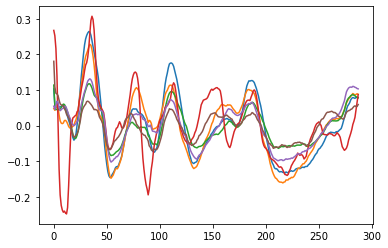

In [52]:
plt.plot(residual_vec)
plt.show()

In [53]:
def calc_theta_r(alpha_r):
    ### return the theta_r in Algorithm 1 , line 6 
    theta = alpha_r/(1+alpha_r)
    return theta

def calc_inter(theta_r, p,q):
    ### return the theta_r in Algorithm 1 , line 7
    gd = mfd.geodesic(p,q)
    return gd(theta_r)

def cyclic_proximal_point_algorithm(data, alpha, lambd,max_itr = 1000):
    """
    Implements the cyclic proximal point algorithm for p-TVq for manifold data.
    
    :param f: Manifold-valued image, numpy array of shape (n, m)
    :param α: Regularization parameter
    :param λ: Sequence for proximal mappings
    :param n: Number of rows in the image
    :param m: Number of columns in the image
    :return: Minimizer x of the p-TVq problem
    """
    Y = np.copy(data)
    n = Y.shape[0]
    mu = np.copy(Y)
    for r in range(max_itr):
        alpha_r = alpha/(r+2)
        for i in range(n-1):
            theta = calc_theta_r(alpha_r)
            mu_i_new  = calc_inter(theta, mu[i],Y[i])
            mu[i] = mu_i_new
        
        for j in range(n-1):
            theta = 0.5* min(lambd*n*alpha_r/mfd.dist(mu[j],mu[j+1]),1)
            mu_j_new = calc_inter(theta, mu[j],mu[j+1])
            mu_j1_new = calc_inter(theta, mu[j+1],mu[j])
            mu[j] =  mu_j_new
            mu[j+1] =mu_j1_new
       
        

    return mu


In [165]:
def cross_validate_lambda(data, alpha, lambda_list, mfd, max_itr=100):
    """
    Perform 2-fold CV over even-indexed time points to select best lambda.
    data: list of length 256 of manifold-valued data
    alpha: fixed hyperparameter for cyclic_proximal_point_algorithm
    lambda_list: list of lambdas to evaluate
    mfd: manifold object with mfd.geodesic(p1, p2)(t) function
    """
    errors = []
    T=data.shape[0]

    even_indices = np.arange(2, T-2, 2)  # exclude boundaries 0 and 254 for safety
    for lambd in lambda_list:
        # Train on odd t
        train_data = [data[t] for t in range(T-2) if t % 2 == 1]
        # Reconstruct full series with estimated values (only odd t used for training)
        muhat = cyclic_proximal_point_algorithm(data=train_data, alpha=alpha, lambd=lambd, max_itr=max_itr)

        total_error = 0.0
        count = 0

        for t in even_indices:
            # Predict using geodesic interpolation between muhat[t-1] and muhat[t+1]
            p1, p2 = muhat[(t - 1) // 2], muhat[(t + 1) // 2]  # map to odd indices in training data
            geod = mfd.geodesic(p1, p2)
            pred = geod(0.5)

            # Compute squared geodesic distance between prediction and true data[t]
            error = mfd.dist(pred, data[t]) ** 2
            total_error += error
            count += 1

        avg_error = total_error / count
        errors.append(avg_error)

    best_idx = int(np.argmin(errors))
    best_lambda = lambda_list[best_idx]

    return best_lambda, errors

In [166]:
data_aug=np.concatenate([data,data[-1].reshape(1,3,3)],axis=0)
lambda_list = [1, 0.5,0.1,0.05, 0.01, 0.0005,0.001,0.0005,0.0001]
best_lambda, error_list = cross_validate_lambda(data_aug, alpha=0.5, lambda_list=lambda_list, mfd=mfd)
print(f"Best lambda: {best_lambda}")

Best lambda: 0.0001


In [167]:

lambd = best_lambda
alpha=0.05

muhat = cyclic_proximal_point_algorithm(data=data_aug, alpha=alpha, lambd=lambd,max_itr = 100)
err = mfd.log(data_aug,muhat)
T = n_windows+1
#muhat.shape,data.shape
xx=np.zeros((T,3,3))
xx[0] =err[0]
for k in range(1,T):
    tmp = err[k]
    now = k
    for j in range(k):
        tmp = mfd.parallel_transport(tmp,muhat[now], end_point=muhat[now-1])
        now=now-1
    xx[k] = tmp
    
xx=100*xx

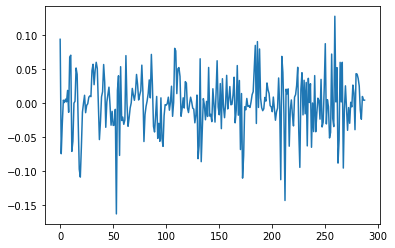

In [168]:
plt.plot(xx[:,0,0])

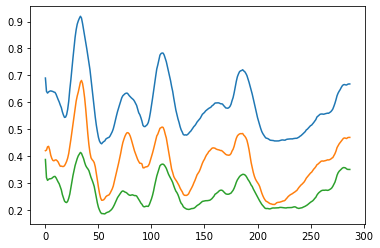

In [173]:
plt.plot(muhat[:,0,:])

In [174]:
#T_lst = [1024]
#T_lst = [2048]   
#tau_lst = [0,0.25,0.5,0.75,1]
#tau_lst = [1.5]
T=data_aug.shape[0]


## sample size
m =  8
n = n_windows // m  # 64
repli_s =100
L = n//2+1
u = (n * np.arange(m) + n / 2) / T
omega = 2 * np.pi * np.arange(1, n + 1) / n
d = 6

#z = np.zeros(repli_s)

 
x = xx.reshape((T,9))
x=x[:,[0,1,2,4,5,8]]
x = x - np.mean(x, axis=0)

D_my = np.zeros((m,L,6),dtype=complex)
for i in range(m):
    low = i*n
    up = (i+1)*n

    D_my[i] =fft.fft(x[low:up],axis=0)[1:(L+1)]#/ np.sqrt(2 * np.pi * n)
    #D_my[i] =fft.rfft(x[low:up],axis=0)[0:L]/np.sqrt(2*np.pi*n)
D_my_conj = np.conj(D_my)
D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

#  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)
#inner_products2 = np.sum(D_conj[:,1:L,:] * D[:, 1:L, :], axis=2)
F1hat =  np.sum(np.square(np.abs(inner_products)))/T

V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
V_conj_transpose = np.conj(V)  # This is the complex conjugate 

# Prepare the arrays for outer product calculation using broadcasting
# Add a new axis to V for broadcasting to work correctly for the outer product
V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :]  # This will have the shape (16, 8, 1, 6)

# Now compute the outer product
Imat = V * V_conj_transpose/d # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

F2hat= Il_sq.mean()/2
Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
mhat = (F1hat-F2hat+Bhat/m)
#mhat = F1_hat-F2_hat
vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/n)
z = np.sqrt(T)*mhat/vhat

In [175]:
print(f"p-value: {stats.norm.cdf(z)}")

p-value: 0.826610434269809


In [ ]:

def resvec_to_sum(res_vec, w=3):
    # local sum
    dim = res_vec.shape[1]
    N = res_vec.shape[0]
    res = np.zeros((N - w + 1, dim))
    for i in range(dim):
        res[:, i] = np.convolve(res_vec[:, i], np.ones(w), 'valid')

    return res


def gamma_m(res_vec, w=3):
    localvar = resvec_to_sum(res_vec, w) ** 2
    n, dim = localvar.shape
    res = np.zeros((n, dim))
    for i in range(dim):
        res[:, i] = np.cumsum(localvar[:, i]) / (w * n)
    return (res)


def resvec_to_sum(res_vec,w=3):
    # local sum
    dim = res_vec.shape[1]
    N = res_vec.shape[0]
    res =np.zeros((N-w+1,dim))
    for i in range(dim):
        res[:,i] = np.convolve(res_vec[:,i], np.ones(w), 'valid')
    
    return res

def gamma_m(res_vec,w=3):
    localvar = resvec_to_sum(res_vec,w)**2
    n,dim = localvar.shape
    res = np.zeros((n,dim))
    for i in range(dim):
        res[:,i] = np.cumsum(localvar[:,i])/(w*n)
    return(res)


def volatity(res_vec,wlst):
    wm =max(wlst)
    L = len(wlst)
    n,dim = res_vec.shape
    localvar_res=np.zeros(shape=(n-wm+1 ,dim,L))
    for i in range(L):
         localvar_res[:,:,i] = gamma_m(res_vec,wlst[i])[:(n-wm+1),]
    
    vol = np.zeros((n-wm+1, dim,L-2))
    for j in range(n-wm+1):
        for k in range(dim):
            for i in range(L-4):
                vol[j,k,i] = np.std(localvar_res[j,k,i:(i+3)])
    
    vol_sum = np.sum(vol,axis=1)
    
    return np.max(vol_sum,axis=0)

def select_window(res_vec,wlst):
    vol = volatity(res_vec,wlst)
    idx = np.argmin(np.max(vol,axis=0))
    return(wlst[idx+1])


def local_sum(res,w=3):
    # local sum for reisduals
    dim = res.shape[1]
    N = res.shape[0]
    locsum =np.zeros((N-w+1,dim))
    for i in range(dim):
        locsum[:,i] = np.convolve(res[:,i], np.ones(w), 'valid')
    
    return locsum

def generate_Phi(locsum):
    #Philst = np.zeros(locsum.shape)
    n = locsum.shape[0]
    g = np.random.normal(size=n)
    g = g.reshape((n,1))
    dPhi = g*locsum
    Phi = np.cumsum(dPhi,axis=0)
    return Phi



In [16]:
data= Pop_cov 
nsamples= 287
data_eu=data.reshape((nsamples,9))
data_eu=data_eu[:,[0,1,2,4,5,8]]
residual = data_eu-np.mean(data_eu,axis=0)
res_cusum =np.cumsum(residual,axis=0)
res_cusum_norm = np.sqrt(np.sum(res_cusum*res_cusum,axis=1))
Tn = res_cusum_norm.max()/np.sqrt(nsamples)

L =max(np.ceil(0.01*nsamples),2)
if(nsamples<100):L=1
U = max(0.05*nsamples+1,6)
windows =np.arange(L,U)
# windows =np.linspace(0.02, 0.05, num=20) * nsample= 400
windows = (np.rint(windows)).astype(int)
w = select_window(residual,windows) 
B =2000# bootstrap size
Boot_Stat= np.zeros(B)

locsum = local_sum(residual,w=w)
for i in range(B):
    #np.random.seed(seed*10000+i)
    Phi = generate_Phi(locsum)/np.sqrt(w*(nsamples-w+1))
    for k in range(nsamples-w+1):

        Phi[k] = Phi[k]-(k+1)/(nsamples-w+1)*Phi[nsamples-w]

    Phinorm = np.sqrt(np.sum(Phi*Phi,axis=1))

    Boot_Stat[i] = np.max(Phinorm[w:])
pval_eu =np.mean(Boot_Stat>=Tn) 


In [17]:
pval_eu

0.0135